# 第十二次课-评分作业

**此次作业<span style="color:red;">成绩计入总评</span>，基础题满分10分，选做题满分1分，选做题共两道，分别为1分，选做任意一道即可，若都做则按得分更高的一道给分**

**请将作业命名为<span style="color:red;">HW12-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">4月18日23:59前</span>提交，做附加题的同学请于<span style="color:red;">4月16日23:59前</span>提交，晚于此时间提交的作业，附加题部分不予批改**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import gzip
import gensim
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

## 第一部分、Embedding (2+1pt)

简单地说，数据科学中的Embedding是指将非数字类型的数据（如文本/单词、图片/视频、音频、图节点/边等）转化为向量，从而方便进行各种运算；这个向量通常有以下几个特点
- (相对)低维，如小于1000维，或者小于原始数据维数的十分之一等，“低”的界定视待处理数据的规模会有所不同
- 稠密/连续，因此TF-IDF、one-hot向量等都不能算是Embedding，但使用SVD进一步降维后的TF-IDF可以算是一种Embedding
- 向量之间的距离、夹角、差值等能够用于衡量原始数据的某种相似性

本部分中，我们将对文本中的单词和图中的节点两种形式的数据进行Embedding

### 1.1 Word2Vec

本部分不要求大家填写代码，仅供大家熟悉gensim中Word2Vec相关操作

Word2Vec算法的直观解释是一个单词前后的其他单词与它本身会有较高的相似性，对于给定的文本中的单词，取出它上下文出现的其他单词，并将它们对应的向量“拉近”；对于不在上下文中单词，则将它们对应的向量“推远”

Word2Vec算法实际上可以看做一个单隐层神经网络，算法细节可以参见[此处](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

#### 数据读取与预处理

In [2]:
with gzip.open('./data/reviews_data.txt.gz', 'rb') as f:
    lines = f.readlines()[:20000]
print(lines[0])

b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

In [3]:
documents = [gensim.utils.simple_preprocess(line) for line in tqdm(lines)]

100%|██████████| 20000/20000 [00:04<00:00, 4603.53it/s]


In [4]:
print(documents[0])

['oct', 'nice', 'trendy', 'hotel', 'location', 'not', 'too', 'bad', 'stayed', 'in', 'this', 'hotel', 'for', 'one', 'night', 'as', 'this', 'is', 'fairly', 'new', 'place', 'some', 'of', 'the', 'taxi', 'drivers', 'did', 'not', 'know', 'where', 'it', 'was', 'and', 'or', 'did', 'not', 'want', 'to', 'drive', 'there', 'once', 'have', 'eventually', 'arrived', 'at', 'the', 'hotel', 'was', 'very', 'pleasantly', 'surprised', 'with', 'the', 'decor', 'of', 'the', 'lobby', 'ground', 'floor', 'area', 'it', 'was', 'very', 'stylish', 'and', 'modern', 'found', 'the', 'reception', 'staff', 'geeting', 'me', 'with', 'aloha', 'bit', 'out', 'of', 'place', 'but', 'guess', 'they', 'are', 'briefed', 'to', 'say', 'that', 'to', 'keep', 'up', 'the', 'coroporate', 'image', 'as', 'have', 'starwood', 'preferred', 'guest', 'member', 'was', 'given', 'small', 'gift', 'upon', 'check', 'in', 'it', 'was', 'only', 'couple', 'of', 'fridge', 'magnets', 'in', 'gift', 'box', 'but', 'nevertheless', 'nice', 'gesture', 'my', 'room

#### 调用Word2Vec

In [5]:
# running time may range from 20s to 1min, depending on your device
model = Word2Vec(min_count=2, window=2, vector_size=100, seed=42)
model.build_vocab(documents)
model.train(documents, total_examples=len(documents), epochs=20)

(48245489, 66357260)

#### Word2Vec结果分析

In [6]:
# 使用similarity来计算单词的相似性
print(model.wv.similarity(w1='dirty', w2='smelly'))
print(model.wv.similarity(w1='dirty', w2='dirty'))
print(model.wv.similarity(w1='dirty', w2='clean'))

0.752678
1.0
0.3438118


In [7]:
# 可以利用词向量的相似性来排除异类单词
print(model.wv.doesnt_match(['good', 'happy', 'positive', 'sad']))
print(model.wv.doesnt_match(['black', 'white', 'yellow', 'do']))
print(model.wv.doesnt_match(['bed', 'pillow', 'duvet', 'shower']))

sad
do
shower


In [8]:
# 词向量的运算能够反映出单词间的某种联系
# 如以下例子中 
# "king" - "man" + "woman" ≈ "queen"
# "better" - "good" + "bad" ≈ "worse"

vec_man = model.wv.get_vector('man')
vec_king = model.wv.get_vector('king')
vec_woman = model.wv.get_vector('woman')

query_vec = vec_king - vec_man + vec_woman
print(model.wv.similar_by_vector(query_vec, topn=5))

vec_good = model.wv.get_vector('good')
vec_better = model.wv.get_vector('better')
vec_bad = model.wv.get_vector('bad')

query_vec = vec_better - vec_good + vec_bad
print(model.wv.similar_by_vector(query_vec, topn=5))

[('king', 0.8384087681770325), ('queen', 0.7465031743049622), ('twin', 0.6723853945732117), ('double', 0.6064078211784363), ('doubles', 0.5890205502510071)]
[('better', 0.763462483882904), ('worse', 0.667439877986908), ('nicer', 0.5695105195045471), ('bad', 0.5018162131309509), ('hotter', 0.48864102363586426)]


### 1.2 Node Embedding (2+1pt)

节点嵌入(Node Embedding)用于将一个图中的节点表示为低维向量，使得对于节点$i,j$和对应的向量$v_i,v_j$，有
$$
\mathrm{Similarity}(i,j) \approx v_i^{\mathrm{T}}v_j
$$
其中$\mathrm{Similarity}$是衡量节点之间相似性的函数，依据任务目标可灵活选择

在本部分中，我们将实现PCA(1pt)、deepwalk(1pt)、Node2Vec(选做, 1pt)三种节点嵌入算法

关于节点嵌入的更多内容可参见[链接](https://web.stanford.edu/class/cs224w/slides/02-nodeemb.pdf)

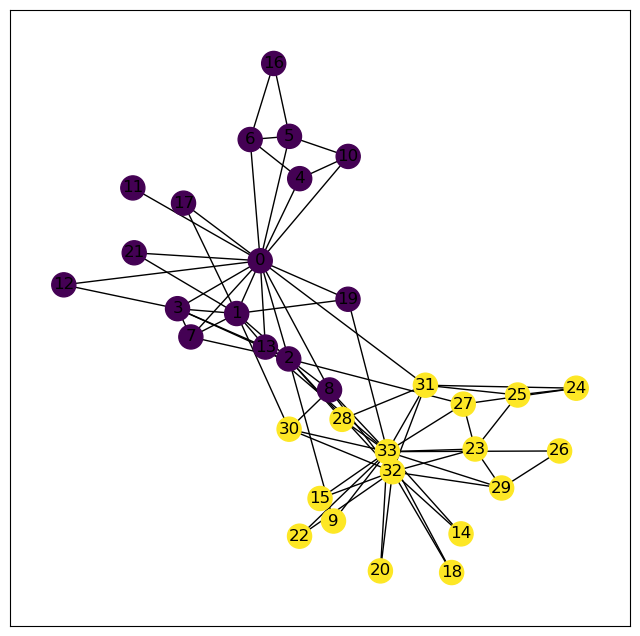

In [9]:
# 定义使用的图数据和可视化函数
G = nx.karate_club_graph()
unique_clubs = list(set(G.nodes[node]['club'] for node in G.nodes))
labels = [unique_clubs.index(G.nodes[node]['club']) for node in G.nodes]

def plot_G(G, labels):
    pos = nx.spring_layout(G, seed=42) 
    plt.figure(figsize=(8, 8))
    nx.draw_networkx(G, pos=pos, node_color=labels)
    plt.show()

def plot_embeddings(embeddings, labels, node_ids):
    # 使用t-SNE将高维向量降维到2D
    tsne = TSNE(
        n_components=2, 
        random_state=42,
        init='random',
        learning_rate=200
    )
    embeddings_2d = tsne.fit_transform(embeddings) 

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, s=100)

    for i, node_id in enumerate(node_ids):
        plt.annotate(node_id, 
                     (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords="offset points", 
                     xytext=(0, 5),
                     fontsize=12, 
                     ha='center', 
                     va='bottom')
    plt.show()

plot_G(G, labels)

#### 1.2.1 PCA (1pt)

In [10]:
def PCA_embed(G, dim):
    pca = PCA(n_components=dim)

    # ----------------------------------------------------
    # TODO (1pt)
    # 使用nx.to_numpy_array(G)得到G的邻接矩阵
    # 将PCA作用在图G的邻接矩阵上，得到降维后的新矩阵命名为embeddings
    g_matrix=nx.to_numpy_array(G)
    embeddings=pca.fit_transform(g_matrix)
    
    # ----------------------------------------------------

    return {str(i): embeddings[i] for i in G}

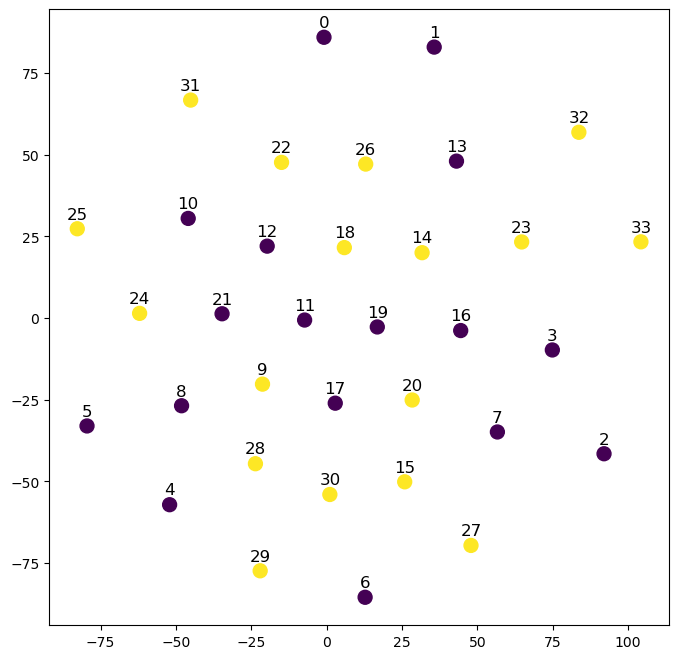

In [11]:
dim = 16
node_ids = [str(i) for i in G]
pca_embeds = PCA_embed(G, dim)
pca_embeds_array = np.array([pca_embeds[i] for i in node_ids])
plot_embeddings(pca_embeds_array, labels, node_ids)

#### 1.2.2 DeepWalk (1pt)

DeepWalk的基本实现步骤为
- 选取一个初始点作为移动起点
- 等概率随机选取一个邻居，移动到邻居节点处
- 不断进行移动，直至移动次数达到设定值，得到一个节点序列，称为一次walk
- 遍历G上的所有顶点，将其作为初始点执行以上步骤，得到|V|次walks

在图上反复执行以上步骤k次，得到k|V|次walks，将节点视为单词，一次walk视为一段文本，并执行Word2Vec

In [12]:
def deep_walk_once(G, start_node, walk_length):
    ''' 调用此函数获得一次walk

    G: 执行deepwalk算法的图
    start_node: 移动起始点
    walk_length: walk的长度
    '''

    walk = [str(start_node)]
    current_node = start_node

    for _ in range(walk_length - 1):
        
        # ----------------------------------------------------
        # TODO (1pt)
        # 获取当前节点的邻居，等概率随机选择一个赋值给current_node
        # 可以使用random.choice从一个列表中随机选择一个元素
        
        neighbors = list(G.neighbors(current_node))
        current_node = random.choice(neighbors)
    
        # ----------------------------------------------------

        walk.append(str(current_node))
    return walk

def deep_walk(G, num_walks, walk_length):
    '''执行deepwalk算法
    
    G: 执行算法使用的图
    num_walks: 需要遍历G上节点的次数，最终的walks总数量为 num_walks * |V|
    walk_length: 每一次walk的长度
    '''

    walks = []
    random.seed(42)

    for _ in range(num_walks):
        for start_node in G.nodes():
            walks.append(deep_walk_once(G, start_node, walk_length))

    return walks


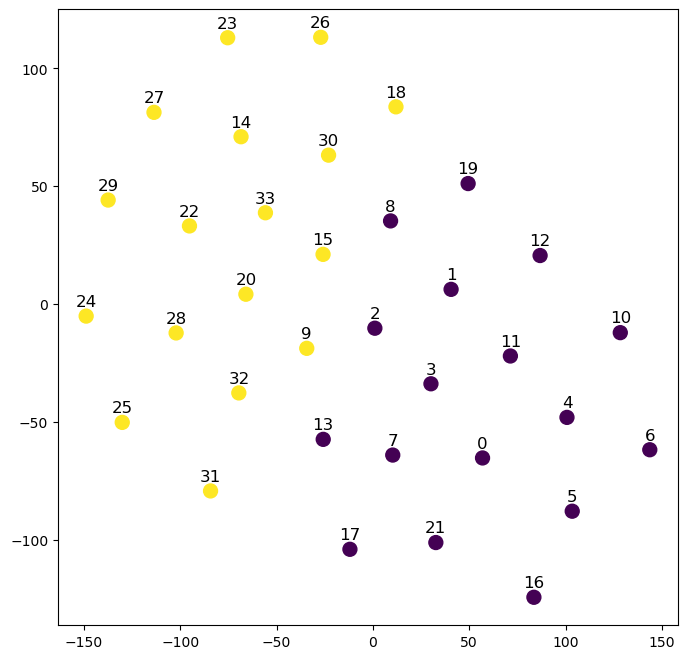

In [13]:
# Word2Vec具有随机性，可视化结果与参考输出不一定相同
walk_length = 30
num_walks = 200 
dimensions = 16 
deepwalk_walks = deep_walk(G, num_walks, walk_length)
deepwalk_model = Word2Vec(deepwalk_walks, 
                          vector_size=dimensions, 
                          window=5, 
                          min_count=1, 
                          sg=1)
deepwalk_embeds = np.array([deepwalk_model.wv[str(node)] for node in G])
plot_embeddings(deepwalk_embeds, labels, node_ids)

#### <b>(选做)</b> 1.2.3 Node2Vec (1pt)

Node2Vec是对DeepWalk的扩展，主要改进为引入两个参数p和q，对随机游走的路线进行控制，具体控制方式如下，假设此时从节点$u$走到节点$v$，并用$\mathcal{N}(w)$表示节点$w$的邻居集合，则
- 给$u$赋一个权重$1/p$
- 对所有$z\in \mathcal{N}(u)\cap \mathcal{N}(v)$，给$z$赋一个权重$1$
- 对所有$z\in \mathcal{N}(v) \setminus \mathcal{N}(u)$且$z\neq u$，给$z$赋一个权重$1/q$

将所有权重归一化，得到$v$下一步往它的各个邻居节点游走的概率

算法的其余部分与DeepWalk一致

In [14]:
def node2vec_once(G, start_node, walk_length, p, q):
    ''' 调用此函数获得一次walk

    G: 执行deepwalk算法的图
    start_node: 移动起始点
    walk_length: walk的长度
    p, q: 控制游走路线的参数
    '''

    walk = [str(start_node)]
    current_node = start_node
    previous_node = None

    for _ in range(walk_length - 1):
        # ----------------------------------------------------
        # TODO (1pt)
        # 补全node2vec算法，选取下一次前往的节点，赋值给current_node

        if previous_node is None:
            # 初次游走，等概率随机选取邻居节点
            neighbors = list(G.neighbors(current_node))
            current_node = random.choice(neighbors)
            previous_node=start_node 
            
        else:
            # 之后的游走，根据p, q参数选择下一个节点
            neighbors = list(G.neighbors(current_node))
            neighbors_pre=list(G.neighbors(previous_node))
            probaility=[]
            for neighbor in neighbors:
                if neighbor==previous_node:
                    probaility.append(1/p)
                elif neighbor in neighbors_pre:
                    probaility.append(1)
                else:
                    probaility.append(1/q)
            probaility=[i/sum(probaility) for i in probaility]
            previous_node = current_node 
            current_node = random.choices(neighbors,k=1,weights=probaility)[0]
            
        # ----------------------------------------------------
        
        walk.append(str(current_node))

    return walk

def node2vec(G, num_walks, walk_length, p, q):
    '''执行node2vec算法
    
    G: 执行算法使用的图
    num_walks: 需要遍历G上节点的次数，最终的walks总数量为 num_walks * |V|
    walk_length: 每一次walk的长度
    p, q: 控制游走路线的参数
    '''

    walks = []
    random.seed(42)

    for _ in range(num_walks):
        for start_node in G.nodes():
            walks.append(node2vec_once(G, start_node, walk_length, p, q))

    return walks


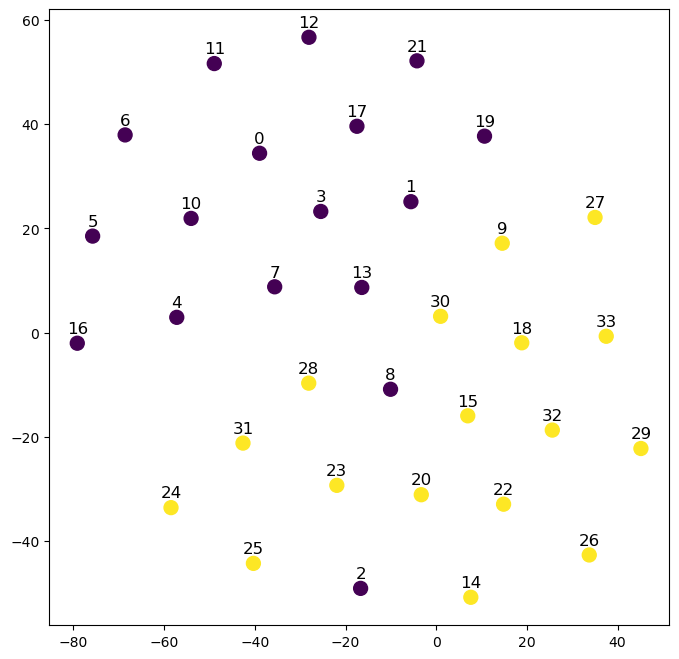

In [15]:
# Word2Vec具有随机性，可视化结果与参考输出不一定相同
G = nx.karate_club_graph()
walk_length = 30
num_walks = 200 
dimensions = 16 
p, q = 0.5, 2
node2vec_walks = node2vec(G, num_walks, walk_length, p, q)
node2vec_model = Word2Vec(node2vec_walks, 
                          vector_size=dimensions, 
                          window=5, 
                          min_count=1, 
                          sg=1)
node2vec_embeds = np.array([node2vec_model.wv[str(node)] for node in G])
plot_embeddings(node2vec_embeds, labels, node_ids)

## 第二部分、PageRank (2pt)

在本部分中，我们将手动实现PageRank算法并绘制算法运行过程的GIF动图；绘图部分的代码框架已经完成，你只需填充PageRank迭代过程的核心算法部分

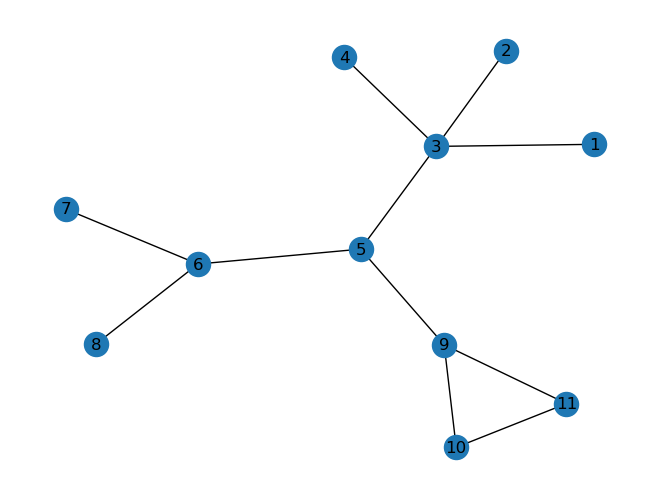

In [16]:
# 以下定义本部分所使用的图数据
# 为简单起见，直接使用无向图
G = nx.Graph()
G.add_nodes_from(range(1, 12))
edges = [
    (1, 3), (2, 3), (3, 4), (3, 5),
    (7, 6), (8, 6), (6, 5), (5, 9),
    (10, 9), (10, 11), (9, 11)
]
G.add_edges_from(edges)

nx.draw_kamada_kawai(G)
pos = nx.kamada_kawai_layout(G)
_ = nx.draw_networkx_labels(G, pos)

In [17]:
def page_rank(G, d=0.85, tol=1e-2, max_iter=100):
    ''' 算法细节参见第11次课件pp.45-49

    G: 执行PageRank算法的图
    d: 阻尼系数
    tol: 停止条件，若某次迭代后的PR值的变化总和不超过tol
         则表明已经收敛，提前退出循环
    max_iter: 最大迭代次数
    '''
    nodes = G.nodes()
    
    # ----------------------------------------------------
    # TODO: 构建A矩阵(定义在PPT page 47)(1pt)
    # Hint：求度数的两种方式
    # - 可以在第0维上对邻接矩阵使用sum求出节点度数向量
    # - 使用G.degree会返回一个列表，列表的每个元素是一个（节点-度数）二元组
    
    transfer=nx.to_numpy_array(G)
    sumlist=np.sum(transfer,axis=0)
    A=transfer/sumlist

    # ----------------------------------------------------


    N = G.number_of_nodes()
    pr = np.ones((N, 1)) / N

    # repeat the initial step twice
    # for matplotlib animation
    yield nodes, pr, "init"
    yield nodes, pr, "init"

    for it in range(max_iter):
        old_pr = pr[:]
        
        # ----------------------------------------------------
        # TODO: 更新PR向量(PPT page 48的随机冲浪模型)(1pt)
        
        a=np.ones((N,1))
        pr=(1-d)/N*a+d*np.dot(A,old_pr)
            
        # ----------------------------------------------------

        yield nodes, pr, it
        err = np.abs(pr - old_pr).sum()
        if err < tol:
            return pr

MovieWriter ffmpeg unavailable; using Pillow instead.


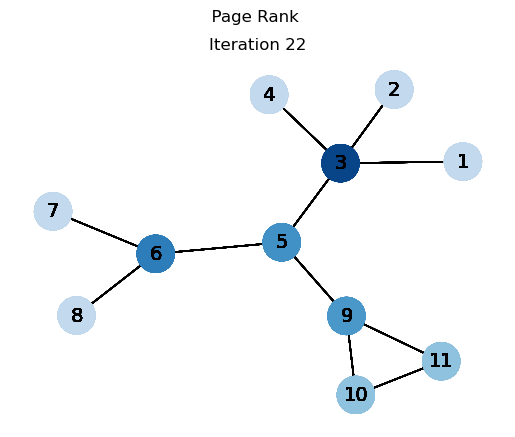

In [18]:
# 以下代码用于生成GIF图，无需改动
def update(r):
    res_nodes, res_values, it = r
    res_values = np.asarray(res_values).ravel()
    plt_nodes = nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        nodelist=res_nodes,
        node_color=res_values,
        alpha=1,
        node_size=700,
        cmap=plt.cm.Blues,
        vmin=0,
        vmax=0.2
    )
    ax.axis('off')
    ax.set_title(f'Iteration {it}')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=14)
    return [plt_nodes, ]

pos = nx.kamada_kawai_layout(G)

f, ax = plt.subplots()
ani = FuncAnimation(
    f,
    update,
    frames=page_rank(G),
    interval=1000,
    blit=True
)
f.suptitle(f'  Page Rank')
ani.save('pagerank.gif')


## 第三部分、社区发现(3pt)

社区发现是指在图中寻找“紧密相连”的子结构，也即一簇相互之间连边密集，但与其他节点连边较稀疏的节点；随着图数据的不断扩大，在整个图上运行算法的代价愈发昂贵，因此，寻找并分析图中有价值的子结构成为研究图数据的重要切入点之一。社区发现的算法十分丰富，这篇[文章](https://zhuanlan.zhihu.com/p/639339969)提供了详尽的总结。

本次作业中，我们使用谱聚类方法和标签传播方法在KarateClub数据集上进行社区发现

### 3.1 谱聚类(Spectral clustering, 1pt)

谱聚类通过在降维后的标准化拉普拉斯矩阵上利用KMeans实现节点聚类，算法如下
- 计算图的标准化拉普拉斯矩阵$L=I-D^{-1/2}AD^{-1/2}$，其中$I$为单位阵，$D_{ii}=d_i$为节点$i$的度数，$D_{ij}=0$，$A$是图的邻接矩阵
- 对$L$进行特征值分解，取最小的$k$个特征值对应的特征向量$U=[u_1,u_2,\cdots,u_k]\in\mathbb{R}^{N\times k}$
- 对$U$进行KMeans聚类

关于谱方法在社群分析和图割上的更多应用，参见[链接](https://web.cs.ucla.edu/~yzsun/classes/2017Winter_CS249/Slides/Clustering2.pdf)

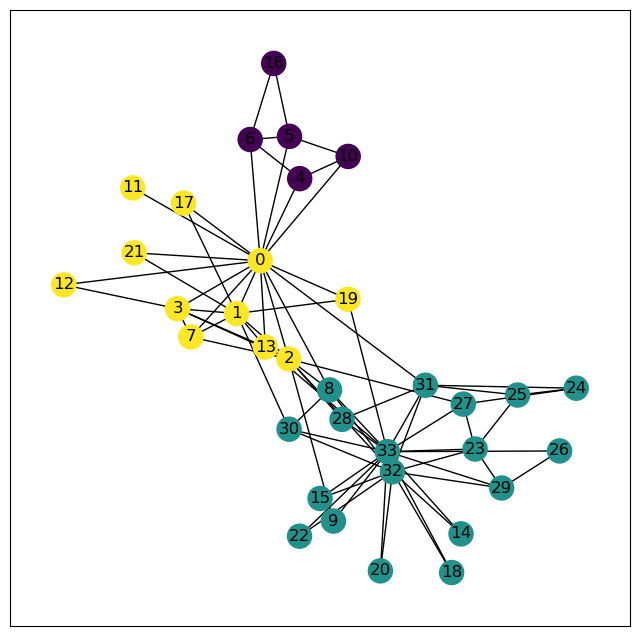

In [19]:
def getNormLaplacian(G):
	'''给定一个图G，计算标准化拉普拉斯矩阵'''

	adjacency_matrix = nx.to_numpy_array(G)

	# ----------------------------------------------------
	# TODO: (1pt) 计算对角矩阵D=diag(d1,d2,...,dn)的-1/2次方，命名为Dn
	# 其中di为节点i的度数
 	# 可以使用np.diag将一维数组变为对角矩阵
    # 可以使用np.linalg.inv对矩阵求逆
	
	sumlist=np.sum(adjacency_matrix,axis=0)
	D=np.diag(sumlist)
	Dn=np.sqrt(np.linalg.inv(D))

	
	# ----------------------------------------------------
 
	L_norm = np.eye(G.number_of_nodes()) - (Dn @ adjacency_matrix @ Dn)
	return L_norm
 
def getKSmallestEigVec(L_norm, k):
	'''给定标准化拉普拉斯矩阵L_norm和k，返回前k小的特征值和对应的特征向量'''
	eigval, eigvec = np.linalg.eigh(L_norm)
	idx = np.argsort(eigval)[:k]
	
	return eigval[idx], eigvec[:, idx]
 
 
G = nx.karate_club_graph()

L_norm = getNormLaplacian(G)
k = 3
kEigVal, kEigVec = getKSmallestEigVec(L_norm, k)
 
kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(kEigVec)

def plot_G_spec(G, kmeans):
    node_color = kmeans.labels_
    pos = nx.spring_layout(G, seed=42) 
    plt.figure(figsize=(8, 8)) 
    nx.draw_networkx(G, pos=pos, node_color=node_color)
    plt.show()

plot_G_spec(G, kmeans)


### 3.2 标签传播算法(LPA, 2pt)

In [20]:
# 实现LPA算法
def lpa(G, max_iter=100):
    random.seed(45)

    # 初始化节点标签
    for node in G:
        G.add_node(node, labels=node)
    t = 1

    # 判断一次迭代中节点标签否有更新
    # 若无更新，则提前退出循环
    is_stopped = False  

    while (t < max_iter) and (not is_stopped):
        t += 1
        is_stopped = True
  
        for node in G:
            # ----------------------------------------------------------------------------
            # TODO: (2pt)
            # 1. 实现LPA算法，可参考https://blog.csdn.net/fengdu78/article/details/124811892
            # 2. 在此基础上添加提前退出的条件，也即当有节点的标签更新时，设置is_stopped为False
            
            old_label= G.nodes[node]['labels']
            count={}
            for nbr in G.neighbors(node):
                label=G.nodes[nbr]['labels']
                count[label]=count.setdefault(label,0)+1
            
            count_items=sorted(count.items(),key=lambda x:-x[-1])
            best_labels=[k for k,v in count_items if v==count_items[0][1]]
            label=random.sample(best_labels,1)[0]
            G.nodes[node]['labels']=label
            if(old_label!=label):
                is_stopped=False
            
            # ----------------------------------------------------------------------------
    return G, t

社区数量 3


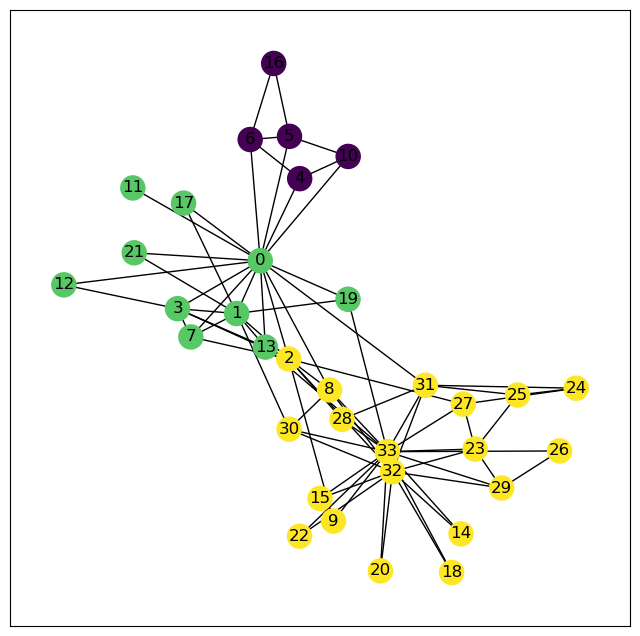

In [21]:
def plot_G_lpa(G):
    node_color = [float(G.nodes[v]['labels']) for v in G]
    pos = nx.spring_layout(G, seed=42) 
    plt.figure(figsize=(8, 8)) 
    nx.draw_networkx(G, pos=pos, node_color=node_color)
    plt.show()

G = nx.karate_club_graph()
G1, t = lpa(G)

assert t < 10
com = set([G1.nodes[node]['labels'] for node in G1])
print('社区数量',len(com))
plot_G_lpa(G1)

## 第四部分、MovieLens用户信息预测（3+1pt）

本部分中，我们使用MovieLens数据集对用户的性别和年龄信息进行预测

### 数据读取

In [22]:
root_path = './data/movielens'
rating_path = os.path.join(root_path, 'ratings.csv')
user_path = os.path.join(root_path, 'users.csv')

ratings = pd.read_csv(rating_path)
users = pd.read_csv(user_path, index_col=0)

In [23]:
ratings

,user_id,1,2,3,4,5,6,7,8,9,...,3942,3943,3945,3946,3947,3948,3949,3950,3951,3952
0,1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
users

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer
...,...,...,...,...,...,...,...
6035,6036,F,25,15,32603,25-34,scientist
6036,6037,F,45,1,76006,45-49,academic/educator
6037,6038,F,56,1,14706,56+,academic/educator
6038,6039,F,45,0,01060,45-49,other or not specified


### 数据预处理（1pt）

提取观影数量不小于100的用户的个人信息和评分信息，分别保存在两个新的DataFrame中，命名为`users_new`和`ratings_new`

In [25]:
# ----------------------------------------------------------------------------
# TODO (1pt)
ratings_new=ratings[np.count_nonzero(ratings,axis=1)>100]
idlst=np.array(ratings_new.user_id)
users_new = users.loc[users['user_id'].isin(idlst)]
# ----------------------------------------------------------------------------

In [26]:
users_new

,user_id,gender,age,occupation,zipcode,age_desc,occ_desc
1,2,M,56,16,70072,56+,self-employed
4,5,M,25,20,55455,25-34,writer
7,8,M,25,12,11413,25-34,programmer
8,9,M,25,17,61614,25-34,technician/engineer
9,10,F,35,1,95370,35-44,academic/educator
...,...,...,...,...,...,...,...
6034,6035,F,25,1,78734,25-34,academic/educator
6035,6036,F,25,15,32603,25-34,scientist
6036,6037,F,45,1,76006,45-49,academic/educator
6038,6039,F,45,0,01060,45-49,other or not specified


In [27]:
ratings_new

,user_id,1,2,3,4,5,6,7,8,9,...,3942,3943,3945,3946,3947,3948,3949,3950,3951,3952
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
9,10,5.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,6035,4.0,0.0,1.0,2.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6035,6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6036,6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,6039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 训练集、测试集划分

In [28]:
X = ratings_new.loc[:, '1':].values
y_age = users_new.loc[:, 'age'].values
y_gender = users_new.loc[:, 'gender'].values
print(X.shape, y_age.shape, y_gender.shape)

(2898, 2925) (2898,) (2898,)


In [29]:
test_ratio = 0.2
N_data = y_age.shape[0]
N_train = int(N_data * (1 - test_ratio))
index = list(range(N_data))
random.seed(42)
random.shuffle(index)

train_index = index[:N_train]
test_index = index[N_train:]

def split_train_test(data: np.ndarray):
    return data[train_index], data[test_index]

In [30]:
X_train, X_test = split_train_test(X)
y_age_train, y_age_test = split_train_test(y_age)
y_gender_train, y_gender_test = split_train_test(y_gender)

### 使用SVC对未处理的特征直接分类 (1pt)

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def svc_classify(X_train, y_train, X_test, y_test):
    # --------------------------------------------------------------
    # TODO (1pt)
    # 构建一个SVC分类器，在X_train和y_train上进行训练
    # 并将对X_test的预测结果赋给名为y_pred的变量
    
    model=SVC()
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)

    # --------------------------------------------------------------

    # 打印评价指标并画热力图
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

以下代码对性别和年龄分别进行预测，运行时间

              precision    recall  f1-score   support

           F       0.76      0.50      0.60       149
           M       0.84      0.94      0.89       431

    accuracy                           0.83       580
   macro avg       0.80      0.72      0.75       580
weighted avg       0.82      0.83      0.82       580



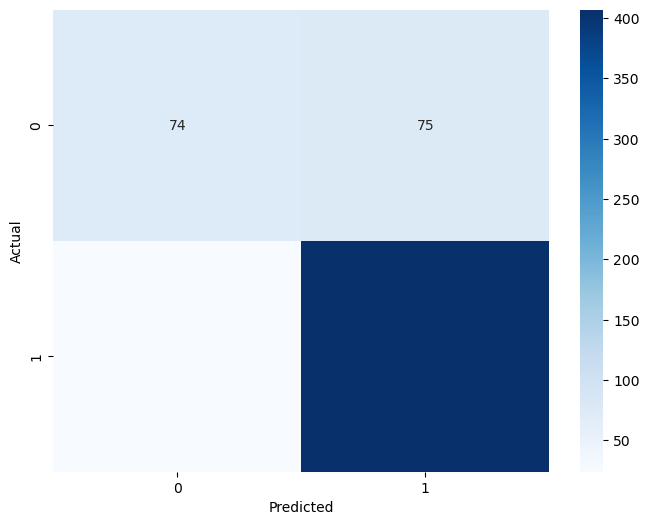

In [32]:
# running time 20s ~ 1min
svc_classify(X_train, y_gender_train, X_test, y_gender_test)

              precision    recall  f1-score   support

           1       1.00      0.05      0.09        22
          18       0.72      0.55      0.63       105
          25       0.57      0.89      0.70       228
          35       0.38      0.45      0.41       109
          45       0.50      0.02      0.04        43
          50       0.33      0.06      0.11        47
          56       0.00      0.00      0.00        26

    accuracy                           0.54       580
   macro avg       0.50      0.29      0.28       580
weighted avg       0.53      0.54      0.48       580



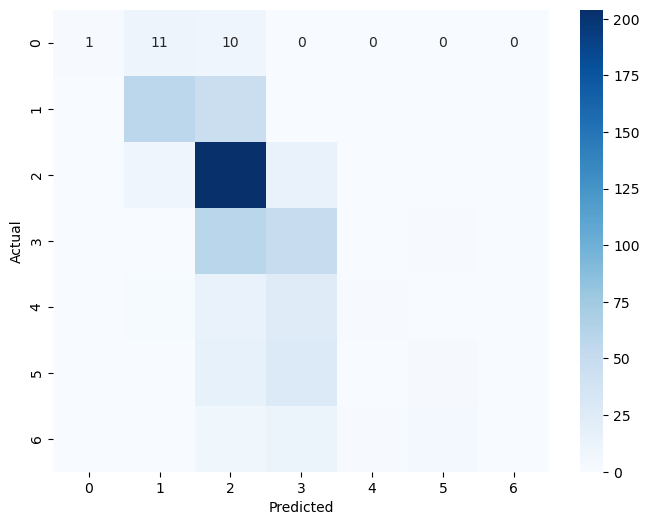

In [33]:
# running time 40s ~ 2min
svc_classify(X_train, y_age_train, X_test, y_age_test)

### 特征嵌入(Feature Embedding, 1pt)

这里的用户-电影评分矩阵像TF-IDF一样，也是一个巨大的稀疏矩阵，并不适合直接用于机器学习，因此，可以借用第一部分中Embedding的想法，对特征进行降维并使之稠密化，再利用新的特征进行预测

注意，在训练过程中，我们认为测试集数据是不可知的，因此特征嵌入方法中涉及的参数只能使用训练集数据获取，再在测试时将这些参数作用在测试集特征上

In [34]:
def feature_embedding(X_train, X_test, **kwargs):
    # ----------------------------------------------------------------------------
    # TODO (1pt) 
    # 自选方法处理特征，使得使用处理后的特征进行**年龄**预测时
    # macro avg F1-score 指标能提高0.08以上
    
    model=PCA(n_components=300)
    X_train_embedded=model.fit_transform(X_train)
    X_test_embedded=model.transform(X_test)
    
    # ----------------------------------------------------------------------------

    return X_train_embedded, X_test_embedded

In [35]:
kwargs = dict()     # Add anything you need
kwargs = {'dim': 700, 'dim2': 300}
X_train_embedded, X_test_embedded = feature_embedding(X_train, X_test, **kwargs)

              precision    recall  f1-score   support

           F       0.72      0.56      0.63       149
           M       0.86      0.93      0.89       431

    accuracy                           0.83       580
   macro avg       0.79      0.74      0.76       580
weighted avg       0.83      0.83      0.83       580



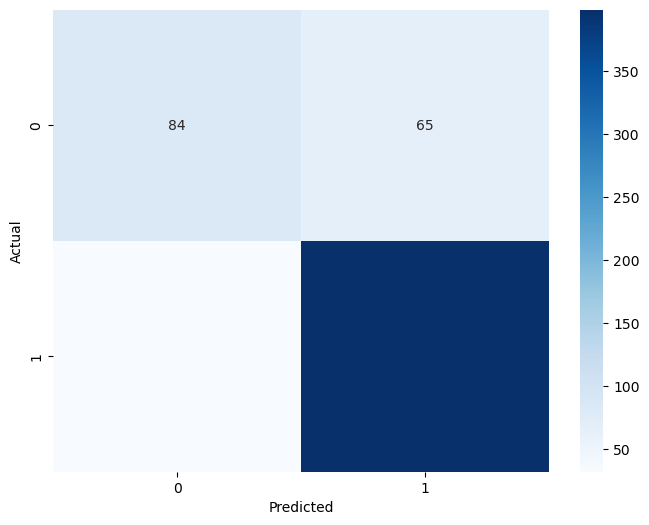

In [36]:
svc_classify(X_train_embedded, y_gender_train, X_test_embedded, y_gender_test)

              precision    recall  f1-score   support

           1       0.67      0.09      0.16        22
          18       0.74      0.66      0.70       105
          25       0.62      0.86      0.72       228
          35       0.41      0.52      0.46       109
          45       0.75      0.07      0.13        43
          50       0.55      0.26      0.35        47
          56       0.50      0.08      0.13        26

    accuracy                           0.59       580
   macro avg       0.60      0.36      0.38       580
weighted avg       0.60      0.59      0.54       580



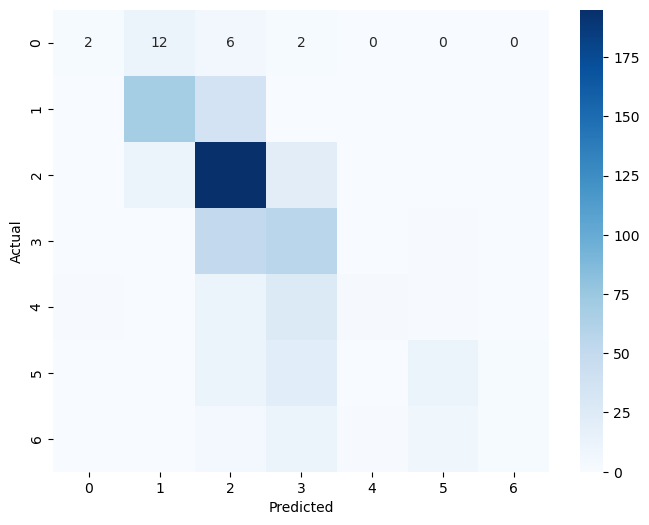

In [37]:
svc_classify(X_train_embedded, y_age_train, X_test_embedded, y_age_test)

### <b>(选做题)</b> 有序分类 (Ordinal Classification, 1pt)

在用户年龄预测问题中，由于年龄段本身是具有序关系的。常规的优化方法（如特征嵌入等）不一定会有明显的效果，我们可以引入一种名为有序分类的方法，在分类过程中加入分类标签的序关系信息

有序分类的一种算法可以参见[这篇文章](https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c)，其核心思想在于将有序多分类问题转换为多个二分类问题。

对某个有序离散的评价指标$Y$，假设其取值可以是$y_1 < y_2 <  \cdots < y_n$，则我们可以训练$n-1$个二分类器$C_1, \cdots, C_{n-1}$，对于一个输入$X$，$C_i(X)$的预测结果$P_i$表示$X$对应的标签$y>y_i$的概率

完成这些分类器的训练后，在预测阶段，给定一个$X$，预测其对应标签$y=y_i$的概率为$P(y>y_{i-1}) - P(y>y_i) = C_{i-1}(X)-C_{i}(X)$，取其中最大的作为$X$的预测标签即可

In [38]:
class OrdinalClassifier:
    def __init__(self, build_classifier, **kwargs):
        self.all_classifiers = []
        self.build_classifier = build_classifier
        self.unique_class = None

    def fit(self, X, y):
        self.all_classifiers = []
        self.unique_class = np.sort(np.unique(y))

        if len(self.unique_class) > 2:
            for i in range(len(self.unique_class) - 1):
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                classifier = self.build_classifier()
                classifier.fit(X, binary_y)
                self.all_classifiers.append(classifier)
    
    def predict(self, X):
        # ----------------------------------------------------------------------------
        # TODO (1pt) 补充predict函数，对输入的X返回预测标签y
        # 可以在保持__init__、fit、predict的参数接口不变的前提下任意修改或增加类的方法和属性

        pass

        # ----------------------------------------------------------------------------

        return y

以下使用OrdinalClassifier对SVC进行包装，并与直接使用SVC的结果进行对比

In [39]:
def eval_classifier(X_train, y_train, X_test, y_test, classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

In [40]:
from sklearn.svm import SVC 

def build_svc():
    return SVC(probability=True)

svc = build_svc()
svc_ord = OrdinalClassifier(build_svc)

eval_classifier(X_train_embedded, y_age_train, X_test_embedded, y_age_test, svc)
eval_classifier(X_train_embedded, y_age_train, X_test_embedded, y_age_test, svc_ord)

              precision    recall  f1-score   support

           1       0.67      0.09      0.16        22
          18       0.74      0.66      0.70       105
          25       0.62      0.86      0.72       228
          35       0.41      0.52      0.46       109
          45       0.75      0.07      0.13        43
          50       0.55      0.26      0.35        47
          56       0.50      0.08      0.13        26

    accuracy                           0.59       580
   macro avg       0.60      0.36      0.38       580
weighted avg       0.60      0.59      0.54       580



NameError: name 'y' is not defined